---
title: Introduction to Push-Forward Generative Models -- Generative Adversarial Networks (GANs)
author: Mark Fuge
date: 'October 12 2025'
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

In this chapter, we will build geometric intuition for push-forward generative models, which are essentially trying to transport probability distributions from one space to another. We will start with simple linear maps to gain a sense of how they modify a simple 2D data space, then scale up to a small MLP GAN on a ring-of-Gaussians toy dataset. We will also talk about common metrics to evaluate generative models. Even though GANs may be comparatively simple compared to more advanced generative models that we will explore later, they will nevertheless be useful in building intuition for how push-forward generative models work.

In [1]:
# Setup and Imports (shared utilities)
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
from matplotlib import pyplot as plt

# Import shared utilities from the local module
from gen_models_utilities import (
    RNG_SEED, device, _compute_axis_limits, create_ring_gaussians, 
    GanHistory, make_loader,
    compute_diversity_metric, plot_model_diagnostics, plot_latent_interpolation,
    make_conditional_loader_onehot, plot_conditional_samples_discrete
)

# get the location of this file
main_fpath = os.path.abspath('')
os.chdir(main_fpath)

# Optional interactive widgets
try:
    from ipywidgets import interact, FloatSlider, IntSlider
except Exception:
    interact = None
    FloatSlider = IntSlider = None



print(f"Using device: {device}")

Using device: cuda


## What are Generative Models really doing?

Fundamentally, generative models are really just functions that transform a probability distribution from one space to another -- you can think of them as "distribution transformers" or, move intuitively, as moving probability mass around in space. As an analogy, consider that you are sitting in a sandbox with a smooth mound of sand in front of you -- the 2D Gaussian that we will use below is not too far from this, actually. A generative model is kind of like your hands, which you can use to push the sand around, creating hills and valleys, and moving the sand from one place to another. In this way, we are essentially moving the probability mass (sand, in this analogy) from a simple distribution (the smooth mound of sand) to a more complex distribution (the hills and valleys that you create with your hands). Different models that we will explore later (e.g., VAEs, normalizing flows, diffusion models) have different ways of doing this, but the core goal is the same, and they essentially all try to do one or more of three operations:

- $f(z) \rightarrow x$: Mapping points from one space (typically called the *latent space*) to another (typically, the *data space*).
- $f^{-1}(x) \rightarrow z$: Mapping points from data space back to latent space.
- $p(x) \Leftrightarrow  p(z)$: Mapping probability densities from data space to latent space (and vice versa).

As we go forward, we will see how different types of models are better or worse at these different operations, and, in some cases, how they can be combined to create more powerful models.

## Basic Deterministic Push-Forward Models: From Latent Space to Data Space

A push-forward generative model defines a mapping $x = f(z)$, where $z$ is sampled from a simple latent distribution (often a standard Gaussian, though it need not be) and $f$ is a deterministic function (e.g., linear map or neural network).

We'll start with a 2D latent $z \sim N(0, I)$ (i.e., a standard Gaussian) and inspect how different choices of $f$ reshape the distribution in data space. In this case, the latent space is 2D and the data space is also 2D, so we can visualize both spaces directly, however, in general, the latent space is often lower-dimensional than the data space.

In [2]:
def plot_pushforward(z: np.ndarray, x: np.ndarray, title: str = "Linear push-forward"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].scatter(z[:, 0], z[:, 1], s=8, alpha=0.35, color='tab:gray')
    axes[0].set_title('Latent samples z ~ N(0, I)')
    axes[0].set_xlabel('z1')
    axes[0].set_ylabel('z2')
    axes[0].axis('equal')
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(x[:, 0], x[:, 1], s=8, alpha=0.5, color='tab:blue')
    axes[1].set_title(title)
    axes[1].set_xlabel('x1')
    axes[1].set_ylabel('x2')
    axes[1].axis('equal')
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

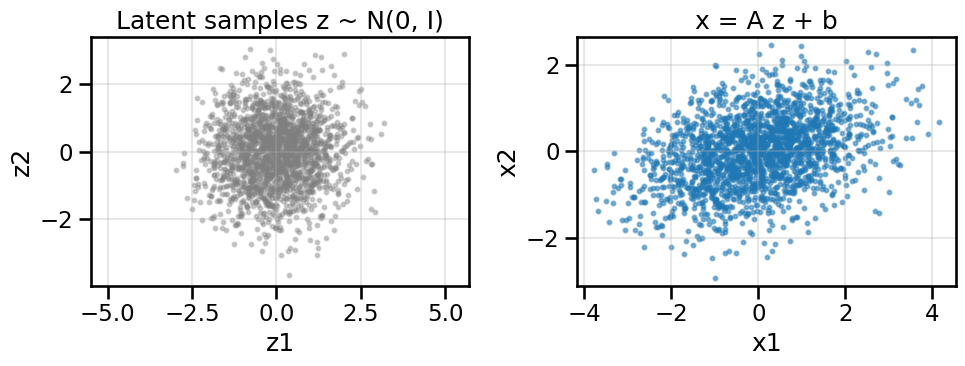

In [3]:
#| code-fold: false
# Linear push-forward demo with interactive sliders
def linear_pushforward_demo(A: np.ndarray, b: np.ndarray, n: int = 1000, seed: int = RNG_SEED):
    rng = np.random.default_rng(seed)
    z = rng.standard_normal(size=(n, 2))
    x = (z @ A.T) + b
    return z, x

# Default transform
A0 = np.array([[1.2, 0.4],[0.0, 0.8]], dtype=float)
b0 = np.array([0.0, 0.0], dtype=float)
z_lin, x_lin = linear_pushforward_demo(A0, b0, n=2000)
plot_pushforward(z_lin, x_lin, title='x = A z + b')


We can see from above that the simple linear map has slightly "moved" or shifted the location of the probability mass, just like if you were sculpting sand in your sandbox. You can play below with some of the sliders to manipulate the simple 2x2 weight matrix and 2x1 bias vector to see how this works interactively:

In [4]:
if interact is not None:
    def _interactive_pushforward(a11=1.2, a12=0.4, a21=0.0, a22=0.8, bx=0.0, by=0.0):
        A = np.array([[a11, a12],[a21, a22]], dtype=float)
        b = np.array([bx, by], dtype=float)
        z, x = linear_pushforward_demo(A, b, n=2000)
        plot_pushforward(z, x, title=f'x = A z + b')
    interact(
        _interactive_pushforward,
        a11=FloatSlider(min=-2.0, max=2.0, step=0.05, value=1.2, description='a11'),
        a12=FloatSlider(min=-2.0, max=2.0, step=0.05, value=0.4, description='a12'),
        a21=FloatSlider(min=-2.0, max=2.0, step=0.05, value=0.0, description='a21'),
        a22=FloatSlider(min=-2.0, max=2.0, step=0.05, value=0.8, description='a22'),
        bx=FloatSlider(min=-2.0, max=2.0, step=0.05, value=0.0, description='b1'),
        by=FloatSlider(min=-2.0, max=2.0, step=0.05, value=0.0, description='b2'),
    )

interactive(children=(FloatSlider(value=1.2, description='a11', max=2.0, min=-2.0, step=0.05), FloatSlider(val…

## Toy Dataset: Ring of Gaussians

OK, now that we have some intuition for how simple linear maps can move probability mass around in space, let's try a more complex example where it is not so clear that a simple linear map will be sufficient. Below, we will create a common toy dataset consisting of a "ring of Gaussians" -- that is, several Gaussian blobs arranged in a circle. You can see from above that no combination of weights in a simple linear map will be able to move our original probability mass from a standard Gaussian to this ring of Gaussians, so we will need something more powerful. A simple starting point for this is something called a Generative Adversarial Network (GAN), which we will explore next.


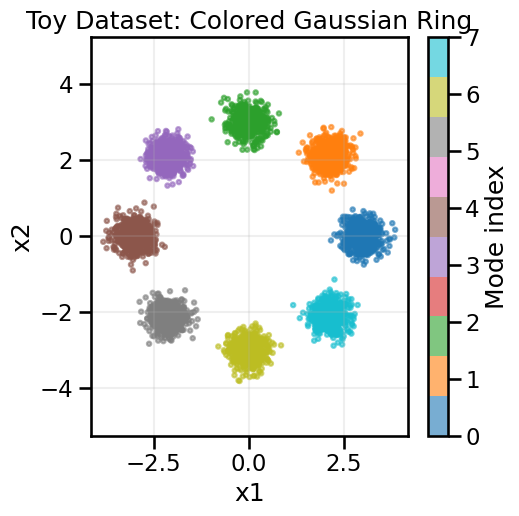

In [5]:
X_ring, y_ring = create_ring_gaussians()
plt.figure(figsize=(5.5,5.5))
sc = plt.scatter(X_ring[:,0], X_ring[:,1], c=y_ring, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(sc, label='Mode index')
plt.title('Toy Dataset: Colored Gaussian Ring')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

ring_latent_limits = ((-3.5, 3.5), (-3.5, 3.5))
ring_data_limits = _compute_axis_limits(X_ring)

## What is a Generative Adversarial Network (GAN)?

A Generative Adversarial Network (GAN) is a framework for training generative models using two competing neural networks: a **generator** and a **discriminator**. The generator, $G$, learns to map random noise from a latent space (e.g., $z \sim p_z(z)$ or $f(z)=x$, where $G$ functions as $f$ here) to data space, aiming to produce samples that resemble the real data. It is tempting to want to train just the Generator by minimizing Mean Squared Error between $z$ and $f(z)=x$, except we have one big problem for right now -- we do not know apriori which samples of $x$ correspond to which samples of $z$, and so it is not straightforward to compute this MSE.[^1] Instead, what we will do is train a separate network, the Discriminator, that can help us push the samples produced by the Generator closer to the real data distribution.

[^1]: Indeed, we will return to this idea in later notebooks once we have introduced the concept of Optimal Transport, which solves this mapping problem, but for now, let's assume that we don't know how to do this. 

Specifically, the discriminator, $D$, tries to distinguish between real data samples and those produced by the generator and our loss function will encourage the discriminator to become better and better at this task. In turn, the generator will be trained to produce samples that the discriminator classifies as real -- that is to try to fool the disciminator.

The two networks are trained simultaneously in something called a *minimax game*:

- The **generator** tries to "fool" the discriminator by generating realistic samples.
- The **discriminator** tries to correctly classify real vs. generated samples.

### Mathematical Formulation

The standard GAN objective, as introduced by Goodfellow et al. (2014), is:

$$
\min_G \max_D \; V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)} \left[ \log D(x) \right] + \mathbb{E}_{z \sim p_z(z)} \left[ \log (1 - D(G(z))) \right]
$$

- $p_{\text{data}}(x)$: Distribution of real data.
- $p_z(z)$: Prior distribution over latent variables (often standard normal).
- $G(z)$: Generator's output given latent input $z$.
- $D(x)$: Discriminator's estimate of the probability that $x$ is real.

The generator and discriminator are typically neural networks trained with stochastic gradient descent. The generator improves by producing samples that the discriminator cannot distinguish from real data (the second term on the right-hand side of the equation above), while the discriminator improves by getting better at distinguishing real from fake (the first term on the right-hand side of the equation above).

## A Simple Generative Adversarial Network (GAN)

Now we will define a small GAN and see how it moves probability mass around after passing samples through the Generator. You can feel free to modify the architecture below if you like and see how that impacts the below results, but for now we will use a single hidden layer MLP with LeakyReLU activation for both the Generator and Discriminator.

In [6]:
#| code-fold: false
class MLPGenerator(nn.Module):
    def __init__(self, noise_dim: int = 2, hidden_dim: int = 256, out_dim: int = 2):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, out_dim),
)
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.main(z)

class MLPDiscriminator(nn.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 256):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x).squeeze(-1)

def build_generator(noise_dim=2, hidden_dim=256):
    return MLPGenerator(noise_dim=noise_dim, hidden_dim=hidden_dim).to(device)

def build_discriminator(hidden_dim=256):
    return MLPDiscriminator(hidden_dim=hidden_dim).to(device)

## Basic Training Loop
With the models defined, we will now set up the training loop to optimize both the generator and discriminator.

In [7]:
#| code-fold: false
def train_vanilla_gan(
    data: np.ndarray, *, noise_dim: int = 2, batch_size: int = 256, epochs: int = 120,
    lr_g: float = 2e-4, lr_d: float = 2e-4, hidden_dim: int = 256, print_every: int = 40) -> tuple[nn.Module, nn.Module, GanHistory]:
    # Load the data into a DataLoader for batching and make PyTorch happy
    loader = make_loader(data, batch_size)

    # Set up the basic networks
    G = build_generator(noise_dim=noise_dim, hidden_dim=hidden_dim)
    D = build_discriminator(hidden_dim=hidden_dim)
    # Instantiate the optimizers for each model
    opt_g = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
    opt_d = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))
    bce = nn.BCEWithLogitsLoss()
    # Record the loss history for plotting later
    hist = GanHistory([], [], [], [], [])

    # Now we do the training loop for # epochs defined in `epochs`
    for ep in range(epochs):
        d_losses=[]
        g_losses=[]
        real_scores=[]
        fake_scores=[]
        for (xb,) in loader:
            # Send the data to the GPU, if using.
            xb = xb.to(device)

            # Take a Discriminator step
            z = torch.randn(xb.size(0), noise_dim, device=device)
            with torch.no_grad():
                x_fake = G(z)
            opt_d.zero_grad()
            d_real = D(xb)
            d_fake = D(x_fake)
            loss_d = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
            loss_d.backward()
            opt_d.step()
            d_losses.append(float(loss_d.detach().cpu().item()))
            real_scores.append(d_real.mean().item())
            fake_scores.append(d_fake.mean().item())

            # Take a Generator step
            z = torch.randn(xb.size(0), noise_dim, device=device)
            opt_g.zero_grad()
            xg = G(z)
            dg = D(xg)
            loss_g = bce(dg, torch.ones_like(dg))
            loss_g.backward()
            opt_g.step()
            g_losses.append(float(loss_g.detach().cpu().item()))
        
        # We'll record some epoch metrics
        with torch.no_grad():
            z_eval = torch.randn(2048, noise_dim, device=device)
            samples = G(z_eval)
            div = compute_diversity_metric(samples)

        # Now we'll record the metrics for plotting later and reporting
        hist.d_loss.append(float(np.mean(d_losses)))
        hist.g_loss.append(float(np.mean(g_losses)))
        hist.diversity.append(div)
        hist.real_scores.append(float(np.mean(real_scores)))
        hist.fake_scores.append(float(np.mean(fake_scores)))
        if (ep+1) % max(1, print_every) == 0 or ep==0:
            print(f"Epoch {ep+1:03d}/{epochs} | D {hist.d_loss[-1]:.3f} | G {hist.g_loss[-1]:.3f} | Div {div:.3f}")
    return G, D, hist

You can feel free to modify some of the training elements here, such as the epoch length or learning rates of the Generator or Discriminator, respectively.

In [8]:
#| code-fold: false
G, D, H = train_vanilla_gan(
    X_ring, epochs=120, batch_size=256, 
    lr_g=2e-4, lr_d=2e-4, 
    hidden_dim=256, noise_dim=2, 
    print_every=40)

Epoch 001/120 | D 1.128 | G 0.734 | Div 0.809
Epoch 040/120 | D 1.300 | G 0.769 | Div 4.310
Epoch 080/120 | D 1.340 | G 0.754 | Div 4.409
Epoch 120/120 | D 1.368 | G 0.732 | Div 4.444


OK, now the model is trained, so let's look at some basic visualizations of how it did. In the below plots, which we will re-use for other models later on, we will show four things:

- Upper Left: Any training losses for the model, as a function of training epoch. In the case of a GAN, this will plot both the Generator and Discriminator losses. This plot type allows us to assess something about the convergence and stability of training.
- Upper Right: The Sample Diversity, as a function of Epoch. This is computing and plotting the variance of $\mathbf{x}$ as a function of epoch, where $\mathbf{x}$ are samples drawn from the Generator at each epoch. This plot type allows us one way to assess whether the model is suffering from mode collapse (i.e., low diversity in the generated samples) or not.
- Lower Right: A plot of the real data samples (in light grey) and samples drawn from the Generator (in reddish-orange). This plot type allows us to visually assess how well the model is capturing the data distribution. This will be easy to compare in this simple 2D case, but will be harder in higher dimensions, and in those cases you might have to resort to just comparing selected samples or overall distribution summary statistics.
- Lower Right: This plot will vary depending on the specific model we are studying, but in this case it will show the specific scores of the Discriminator (often called the "Critic") with respect to its classification accuracy on real vs. fake samples. In the context of a GAN model, this allows us to assess how well a Generator is fooling the discriminator, since a well-trained Generator should produce samples that the Discriminator classifies as real, and thus both the "Real Score" and "Fake Score" should have around 50% accuracy. (i.e., the Discriminator is effectively guessing randomly).


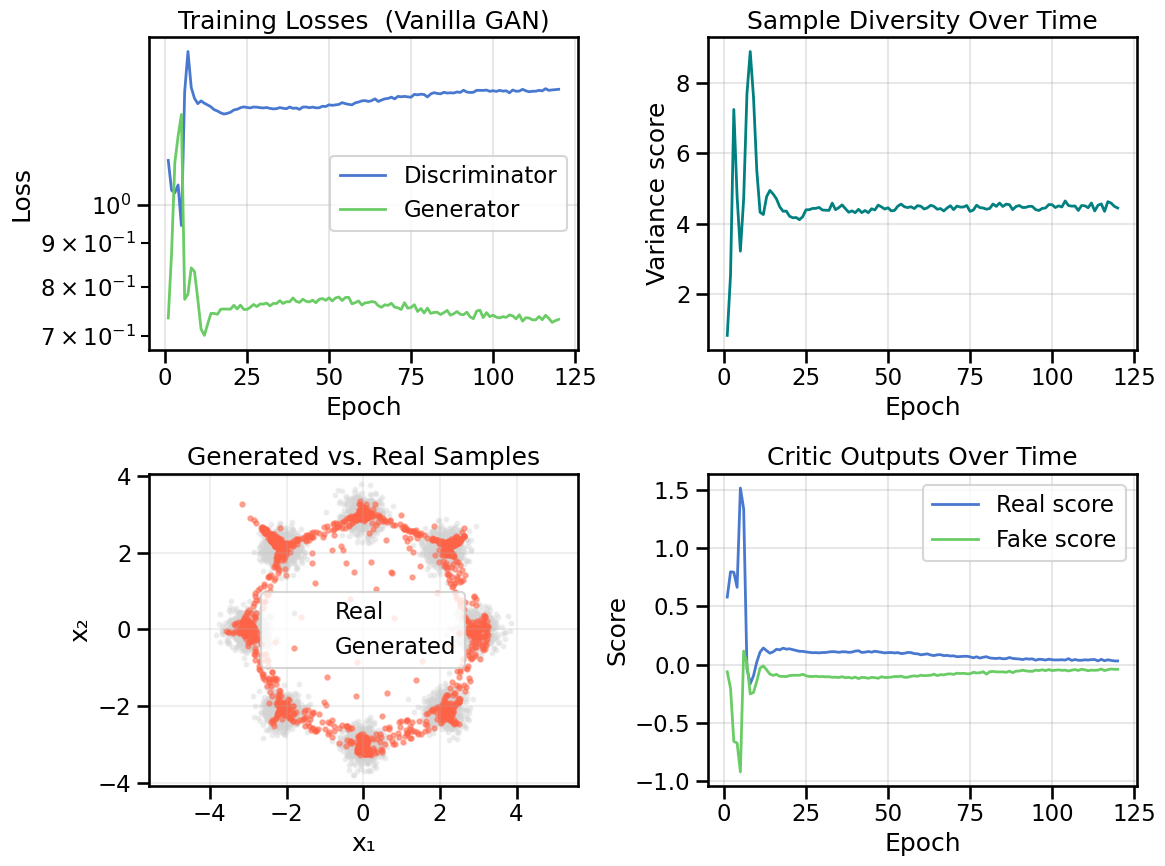

In [9]:
plot_model_diagnostics(H, X_ring, G, noise_dim=2, title_suffix=' (Vanilla GAN)')

In addition to the above training diagnostics, it can also be useful to plot interpolations in latent space to see how smoothly the Generator can move between different modes of the data distribution. In the case of a well-trained GAN, we would expect that interpolating between two points in latent space should produce a smooth transition in data space, moving through intermediate samples that also look realistic. In this case, this means hopping smoothly between the different Gaussian blobs in our ring-of-Gaussians dataset, and not jumping back-and-forth randomly between them.

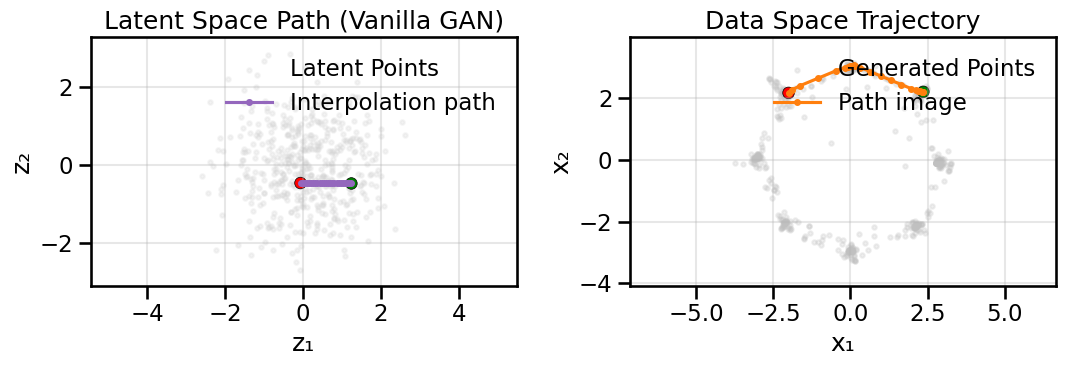

In [10]:
plot_latent_interpolation(G, noise_dim=2, title_suffix=' (Vanilla GAN)')

To give you some interactive control on visualizing the forward mapping $f(z) \rightarrow x$, use the sliders below to move a single latent vector (left-side plot) and observe the corresponding generated point in data space (right-side plot). By moving around in $z$ you can try to align the generated point with a particular mode on the ring. 

In [11]:
if interact is not None:
    def _move_latent(z1: float = 0.0, z2: float = 0.0):
        """
        Visualize the effect of moving a latent vector z = [z1, z2] through the generator.
        Left: latent space (z1, z2) with current point highlighted.
        Right: generated data point in data space, overlaid on the real data.
        """
        z = torch.tensor([[z1, z2]], dtype=torch.float32, device=device)
        with torch.no_grad():
            x = G(z).cpu().numpy()[0]

        fig, axes = plt.subplots(1, 2, figsize=(11, 5))

        # Left: latent space
        axes[0].scatter(0, 0, s=40, color='gray', alpha=0.2, label='Origin')
        axes[0].scatter(z1, z2, s=120, color='crimson', edgecolors='k', linewidths=0.5, label='Current z')
        axes[0].set_title('Latent Space (z)')
        axes[0].set_xlabel('z1')
        axes[0].set_ylabel('z2')
        axes[0].set_xlim(ring_latent_limits[0])
        axes[0].set_ylim(ring_latent_limits[1])
        axes[0].grid(True, alpha=0.3)
        axes[0].legend(loc='upper left', frameon=False)

        # Right: data space
        axes[1].scatter(X_ring[:,0], X_ring[:,1], s=10, alpha=0.15, color='gray', label='Real')
        axes[1].scatter([x[0]], [x[1]], s=120, color='crimson', edgecolors='k', linewidths=0.5, label='Generated')
        axes[1].set_title('Generated Data Point')
        axes[1].set_xlabel('x1')
        axes[1].set_ylabel('x2')
        axes[1].set_xlim(ring_data_limits[0])
        axes[1].set_ylim(ring_data_limits[1])
        axes[1].grid(True, alpha=0.3)
        axes[1].legend(loc='upper left', frameon=False)

        plt.tight_layout()
        plt.show()
    interact(
        _move_latent,
        z1=FloatSlider(min=-3.0, max=3.0, step=0.05, value=0.0, description='z1'),
        z2=FloatSlider(min=-3.0, max=3.0, step=0.05, value=0.0, description='z2'),
    )
else:
    print('ipywidgets not available; skipping latent sliders.')

interactive(children=(FloatSlider(value=0.0, description='z1', max=3.0, min=-3.0, step=0.05), FloatSlider(valu…

## Conditional Generation Examples

So far, we've explored unconditional generative models that learn to produce samples from the overall data distribution. However, in many practical applications, we want to control what we generate by conditioning on additional information. For example, we might want to generate samples from a specific mode of the distribution, or generate samples with particular properties.

In this section, we'll explore two types of conditioning:

1. **Discrete Conditioning (One-Hot Mode Index):** Condition the GAN on which Gaussian mode in our ring dataset the sample should come from.
2. **Continuous Conditioning (Radius):** Condition the GAN on a continuous scalar representing the radius from the origin.

These conditioning strategies are widely applicable and form the basis for more complex conditional generation tasks, such as class-conditional image generation or text-to-image synthesis.

### Conditional Example A — One-Hot Mode Conditioning

In this example, we'll condition the GAN on which of the 8 Gaussian modes in the ring dataset we want to generate from. We provide a one-hot encoded vector indicating the target mode to both the generator and discriminator.

The key idea is simple: we concatenate the one-hot label to the inputs of both networks. The generator receives both random noise $z$ and the label $y$, learning to map $(z, y) \rightarrow x$. The discriminator receives both the data point $x$ and the label $y$, learning to distinguish real pairs $(x, y)$ from fake pairs $(G(z, y), y)$.

In [12]:
#| code-fold: false
# Conditional Generator: takes noise + one-hot label
class ConditionalMLPGenerator(nn.Module):
    def __init__(self, noise_dim: int = 2, label_dim: int = 8, hidden_dim: int = 256, out_dim: int = 2):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(noise_dim + label_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # Concatenate noise and label
        zy = torch.cat([z, y], dim=1)
        return self.main(zy)

# Conditional Discriminator: takes data + one-hot label
class ConditionalMLPDiscriminator(nn.Module):
    def __init__(self, input_dim: int = 2, label_dim: int = 8, hidden_dim: int = 256):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim + label_dim, hidden_dim), nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        xy = torch.cat([x, y], dim=1)
        return self.main(xy).squeeze(-1)

def train_conditional_gan_onehot(
    data: np.ndarray, labels: np.ndarray, n_classes: int = 8, *,
    noise_dim: int = 2, batch_size: int = 256, epochs: int = 120,
    lr_g: float = 2e-4, lr_d: float = 2e-4, hidden_dim: int = 256, print_every: int = 40
) -> tuple[nn.Module, nn.Module, GanHistory]:
    loader = make_conditional_loader_onehot(data, labels, batch_size, n_classes)
    G = ConditionalMLPGenerator(noise_dim=noise_dim, label_dim=n_classes, hidden_dim=hidden_dim).to(device)
    D = ConditionalMLPDiscriminator(input_dim=2, label_dim=n_classes, hidden_dim=hidden_dim).to(device)
    opt_g = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
    opt_d = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))
    bce = nn.BCEWithLogitsLoss()
    hist = GanHistory([], [], [], [], [])

    for ep in range(epochs):
        d_losses, g_losses, real_scores, fake_scores = [], [], [], []
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            # Discriminator step
            z = torch.randn(xb.size(0), noise_dim, device=device)
            with torch.no_grad():
                x_fake = G(z, yb)
            opt_d.zero_grad()
            d_real = D(xb, yb)
            d_fake = D(x_fake, yb)
            loss_d = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
            loss_d.backward()
            opt_d.step()
            d_losses.append(float(loss_d.detach().cpu().item()))
            real_scores.append(d_real.mean().item())
            fake_scores.append(d_fake.mean().item())

            # Generator step
            z = torch.randn(xb.size(0), noise_dim, device=device)
            opt_g.zero_grad()
            xg = G(z, yb)
            dg = D(xg, yb)
            loss_g = bce(dg, torch.ones_like(dg))
            loss_g.backward()
            opt_g.step()
            g_losses.append(float(loss_g.detach().cpu().item()))
        
        with torch.no_grad():
            z_eval = torch.randn(2048, noise_dim, device=device)
            y_eval = torch.nn.functional.one_hot(
                torch.randint(0, n_classes, (2048,), device=device), num_classes=n_classes
            ).to(torch.float32)
            samples = G(z_eval, y_eval)
            div = compute_diversity_metric(samples)

        hist.d_loss.append(float(np.mean(d_losses)))
        hist.g_loss.append(float(np.mean(g_losses)))
        hist.diversity.append(div)
        hist.real_scores.append(float(np.mean(real_scores)))
        hist.fake_scores.append(float(np.mean(fake_scores)))
        if (ep+1) % max(1, print_every) == 0 or ep==0:
            print(f"Epoch {ep+1:03d}/{epochs} | D {hist.d_loss[-1]:.3f} | G {hist.g_loss[-1]:.3f} | Div {div:.3f}")
    return G, D, hist

# Train the conditional GAN
G_cond_onehot, D_cond_onehot, H_cond_onehot = train_conditional_gan_onehot(
    X_ring, y_ring, n_classes=8, epochs=480, batch_size=256, 
    lr_g=2e-4, lr_d=2e-4, hidden_dim=256, noise_dim=2, print_every=40
)

Epoch 001/480 | D 1.250 | G 0.706 | Div 0.029
Epoch 040/480 | D 1.399 | G 0.691 | Div 4.734
Epoch 080/480 | D 1.386 | G 0.697 | Div 4.626
Epoch 120/480 | D 1.387 | G 0.689 | Div 4.322
Epoch 160/480 | D 1.385 | G 0.707 | Div 4.171
Epoch 200/480 | D 1.401 | G 0.658 | Div 3.566
Epoch 240/480 | D 1.390 | G 0.710 | Div 4.966
Epoch 280/480 | D 1.387 | G 0.702 | Div 4.233
Epoch 320/480 | D 1.384 | G 0.708 | Div 4.220
Epoch 360/480 | D 1.386 | G 0.680 | Div 4.759
Epoch 400/480 | D 1.388 | G 0.699 | Div 4.590
Epoch 440/480 | D 1.387 | G 0.682 | Div 4.703
Epoch 480/480 | D 1.388 | G 0.700 | Div 4.429


Now let's visualize the conditional samples. We'll generate samples for each of the 8 modes and plot them to see if the generator has learned to respect the conditioning signal.

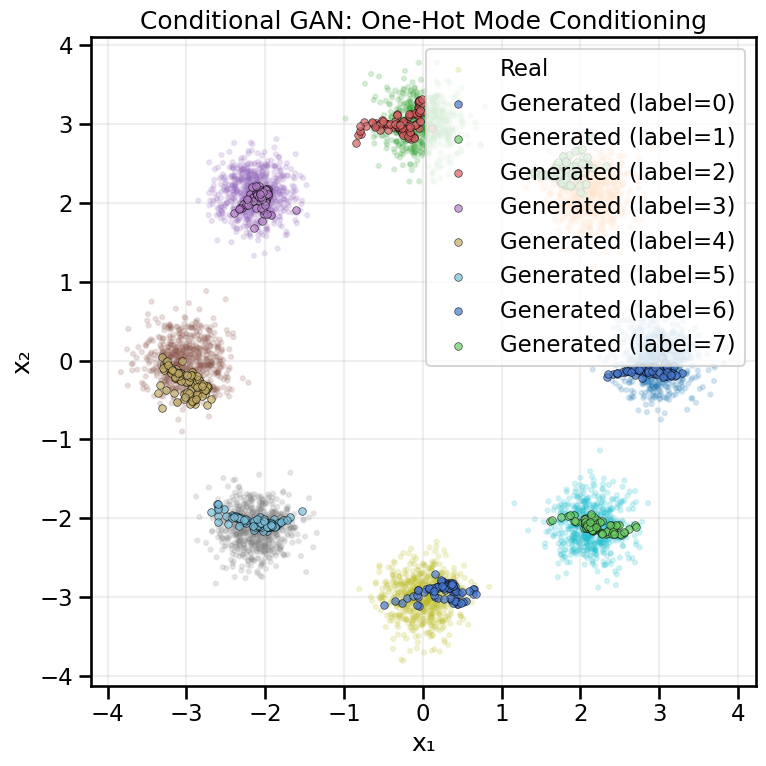

In [13]:
# Generate conditional samples for each mode
G_cond_onehot.eval()
samples_by_label = {}
n_samples_per_mode = 100

for label in range(8):
    z = torch.randn(n_samples_per_mode, 2, device=device)
    y = torch.nn.functional.one_hot(
        torch.full((n_samples_per_mode,), label, device=device), num_classes=8
    ).to(torch.float32)
    with torch.no_grad():
        samples = G_cond_onehot(z, y).cpu().numpy()
    samples_by_label[label] = samples

plot_conditional_samples_discrete(
    samples_by_label, X_ring, y_ring, title="Conditional GAN: One-Hot Mode Conditioning"
)

### Conditional Example B — Continuous Radius Conditioning

Instead of conditioning on discrete labels, we can also condition on continuous scalar values. In this example, we'll condition the GAN on the radius (distance from the origin) of the generated samples. This allows us to control where on the ring samples are generated.

To handle continuous conditioning, we typically embed the scalar through a small MLP before concatenating it with other inputs. This gives the network more flexibility in how it uses the conditioning signal.

In [14]:
#| code-fold: false
from gen_models_utilities import make_conditional_loader_radius, plot_conditional_samples_continuous

# Conditional Generator with radius embedding
class ConditionalMLPGeneratorRadius(nn.Module):
    def __init__(self, noise_dim: int = 2, cond_emb_dim: int = 16, hidden_dim: int = 256, out_dim: int = 2):
        super().__init__()
        # Embed the scalar radius into a higher-dimensional space
        self.cond_embed = nn.Sequential(
            nn.Linear(1, cond_emb_dim),
            nn.LeakyReLU(),
            nn.Linear(cond_emb_dim, cond_emb_dim),
        )
        self.main = nn.Sequential(
            nn.Linear(noise_dim + cond_emb_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, z: torch.Tensor, r: torch.Tensor) -> torch.Tensor:
        r_emb = self.cond_embed(r)
        zr = torch.cat([z, r_emb], dim=1)
        return self.main(zr)

# Conditional Discriminator with radius embedding
class ConditionalMLPDiscriminatorRadius(nn.Module):
    def __init__(self, input_dim: int = 2, cond_emb_dim: int = 16, hidden_dim: int = 256):
        super().__init__()
        self.cond_embed = nn.Sequential(
            nn.Linear(1, cond_emb_dim),
            nn.LeakyReLU(),
            nn.Linear(cond_emb_dim, cond_emb_dim),
        )
        self.main = nn.Sequential(
            nn.Linear(input_dim + cond_emb_dim, hidden_dim), nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, x: torch.Tensor, r: torch.Tensor) -> torch.Tensor:
        r_emb = self.cond_embed(r)
        xr = torch.cat([x, r_emb], dim=1)
        return self.main(xr).squeeze(-1)

def train_conditional_gan_radius(
    data: np.ndarray, *,
    noise_dim: int = 2, batch_size: int = 256, epochs: int = 120,
    lr_g: float = 2e-4, lr_d: float = 2e-4, hidden_dim: int = 256, print_every: int = 40
) -> tuple[nn.Module, nn.Module, GanHistory]:
    loader = make_conditional_loader_radius(data, batch_size)
    G = ConditionalMLPGeneratorRadius(noise_dim=noise_dim, hidden_dim=hidden_dim).to(device)
    D = ConditionalMLPDiscriminatorRadius(input_dim=2, hidden_dim=hidden_dim).to(device)
    opt_g = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
    opt_d = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))
    bce = nn.BCEWithLogitsLoss()
    hist = GanHistory([], [], [], [], [])

    for ep in range(epochs):
        d_losses, g_losses, real_scores, fake_scores = [], [], [], []
        for xb, rb in loader:
            xb, rb = xb.to(device), rb.to(device)
            # Discriminator step
            z = torch.randn(xb.size(0), noise_dim, device=device)
            with torch.no_grad():
                x_fake = G(z, rb)
            opt_d.zero_grad()
            d_real = D(xb, rb)
            d_fake = D(x_fake, rb)
            loss_d = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
            loss_d.backward()
            opt_d.step()
            d_losses.append(float(loss_d.detach().cpu().item()))
            real_scores.append(d_real.mean().item())
            fake_scores.append(d_fake.mean().item())

            # Generator step
            z = torch.randn(xb.size(0), noise_dim, device=device)
            opt_g.zero_grad()
            xg = G(z, rb)
            dg = D(xg, rb)
            loss_g = bce(dg, torch.ones_like(dg))
            loss_g.backward()
            opt_g.step()
            g_losses.append(float(loss_g.detach().cpu().item()))
        
        with torch.no_grad():
            z_eval = torch.randn(2048, noise_dim, device=device)
            r_eval = torch.norm(torch.randn(2048, 2), dim=1, keepdim=True).to(device)
            samples = G(z_eval, r_eval)
            div = compute_diversity_metric(samples)

        hist.d_loss.append(float(np.mean(d_losses)))
        hist.g_loss.append(float(np.mean(g_losses)))
        hist.diversity.append(div)
        hist.real_scores.append(float(np.mean(real_scores)))
        hist.fake_scores.append(float(np.mean(fake_scores)))
        if (ep+1) % max(1, print_every) == 0 or ep==0:
            print(f"Epoch {ep+1:03d}/{epochs} | D {hist.d_loss[-1]:.3f} | G {hist.g_loss[-1]:.3f} | Div {div:.3f}")
    return G, D, hist

# Train the conditional GAN with radius conditioning
G_cond_radius, D_cond_radius, H_cond_radius = train_conditional_gan_radius(
    X_ring, epochs=480, batch_size=256, 
    lr_g=2e-4, lr_d=2e-4, hidden_dim=256, noise_dim=2, print_every=40
)

Epoch 001/480 | D 1.295 | G 0.732 | Div 0.012
Epoch 040/480 | D 1.100 | G 1.071 | Div 0.335
Epoch 080/480 | D 1.265 | G 0.834 | Div 3.910
Epoch 120/480 | D 1.242 | G 0.807 | Div 1.787
Epoch 160/480 | D 1.284 | G 0.801 | Div 1.194
Epoch 200/480 | D 1.323 | G 0.774 | Div 1.310
Epoch 240/480 | D 1.341 | G 0.758 | Div 1.311
Epoch 280/480 | D 1.351 | G 0.736 | Div 1.299
Epoch 320/480 | D 1.355 | G 0.731 | Div 1.255
Epoch 360/480 | D 1.367 | G 0.729 | Div 1.294
Epoch 400/480 | D 1.362 | G 0.722 | Div 1.245
Epoch 440/480 | D 1.359 | G 0.721 | Div 1.224
Epoch 480/480 | D 1.365 | G 0.725 | Div 1.226


Now let's generate samples at different radius values to see how the generator responds to continuous conditioning. We'll sweep through several radius values and visualize the results.

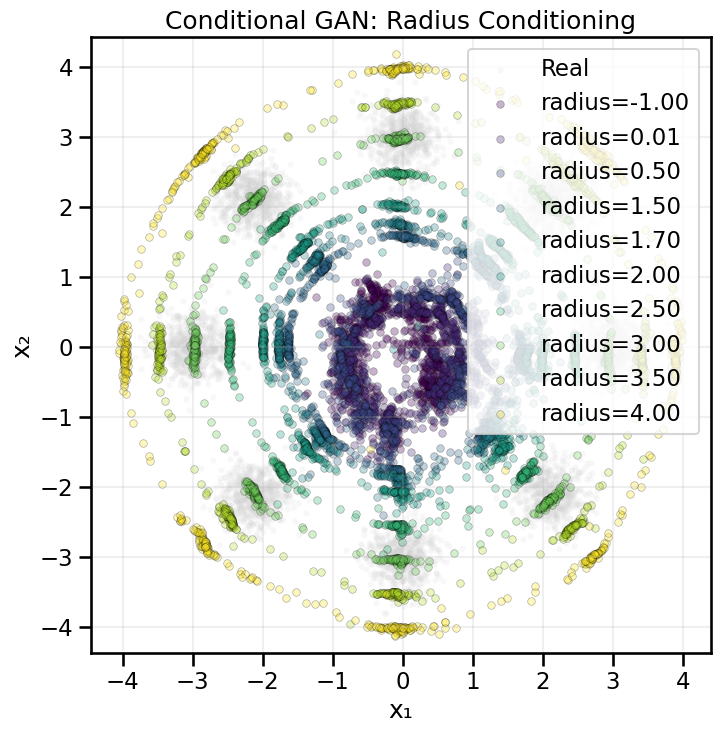

In [17]:
# Generate conditional samples for different radius values
G_cond_radius.eval()
samples_by_radius = {}
n_samples_per_radius = 800
radius_values = [-1.0 , 0.01, 0.5, 1.5, 1.7, 2.0, 2.5, 3.0, 3.5, 4.0]

for r_val in radius_values:
    z = torch.randn(n_samples_per_radius, 2, device=device)
    r = torch.full((n_samples_per_radius, 1), r_val, device=device)
    with torch.no_grad():
        samples = G_cond_radius(z, r).cpu().numpy()
    samples_by_radius[r_val] = samples

plot_conditional_samples_continuous(
    samples_by_radius, X_ring, title="Conditional GAN: Radius Conditioning", value_name="radius"
)

## Summary and Next Steps:

OK, so we have seen how a basic GAN is set up and trained, and covered some diagnostic plots that give us insight into how the training went. This gave us the following sets of useful tools:

- We could learn a forward mapping function $f(z) \rightarrow x$ that could push forward a given sample in $z$ to a corresponding sample in $x$. This could learn distributions that were far more complex than a simple linear map could achieve above. 
- This $f$ is a deterministic function -- i.e., the same $z$ will always produce the same $x$.
- We could produce latent interpolations in $z$ that produced smooth transitions in $x$ and seemed to capture the overall clustering behavior of certain distributions.

Unfortunately, GANs did not give us any of the following properties, which will turn out to be useful later and motivate other types of generative models:

- We did not learn an inverse mapping $f^{-1}(x) \rightarrow z$. This means that we cannot easily encode real data samples into the latent space, which would be useful for many applications. For example, if I wanted to slightly modify $x$ -- e.g., $x^\prime = x+\delta x$ -- and compute the corresponding latent coordinate $z^\prime = z+\delta z$, GANS do not provide a built-it mechanism to do this.[^2] We will see how both Variational Autoencoders (VAEs) and Normalizing Flows (NFs) address this problem.
- We also cannot yet easily talk about or compute probability mappings between $p(x)$ and $p(z)$, which would be useful for computing likelihoods of data samples or for evaluating how well the model fits the data distribution, both of which are quite useful. Again, we will see later how both VAEs and NFs address this problem.

Before we move beyond GANs, however, we will first explore some of the complex training dynamics and other subtle issues that arise when applying them in practice. This will help you build up your intuition and experience in how to assess problems in generative models and will serve as a strong basis upon which to launch into more complex models later. It will also give us an opportunity to introduce the concept of **Optimal Transport**, which will be useful in its own right applications later on, and will also help us understand some of the limitations of GANs should you encounter their use in the future.

[^2]: Of course, I could try to get at this another way, for example, by applying automatic differentiation to the Generator to compute $\frac{\partial f}{\partial z}$ and then use that to estimate $\delta z \approx (\frac{\partial f}{\partial z})^{-1} \delta x$, but this requires extra work on our part and this is not always straightforward, especially if the Jacobian is ill-conditioned.